# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras_hist_graph import plot_history

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [2]:
train_dir = 'dogs_224/train/'
validation_dir = 'dogs_224/validation/'
test_dir = 'dogs_224/test/'

STD_SIZE = (224, 224)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [3]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 224, 224, 3)


In [4]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  236
Number of train classes:  2
Number of train samples per class: 118 

Number of validation samples:  50
Number of validation classes:  2
Number of validation samples per class: 25 

Number of test samples:  51
Number of test classes:  2
Number of test samples per class: 26 

Files for train subset for 2 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

# Model

In [5]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [6]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 6s - loss: 0.7885 - acc: 0.4907 - val_loss: 0.5788 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.57885, saving model to tl_freeze_conv_base_data_aug_2_breeds
Epoch 2/1000
 - 3s - loss: 0.7391 - acc: 0.5417 - val_loss: 0.5272 - val_acc: 0.9000

Epoch 00002: val_loss improved from 0.57885 to 0.52725, saving model to tl_freeze_conv_base_data_aug_2_breeds
Epoch 3/1000
 - 2s - loss: 0.5918 - acc: 0.6944 - val_loss: 0.4565 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.52725 to 0.45655, saving model to tl_freeze_conv_base_data_aug_2_breeds
Epoch 4/1000
 - 2s - loss: 0.5808 - acc: 0.7000 - val_loss: 0.4146 - val_acc: 0.9750

Epoch 00004: val_loss improved from 0.45655 to 0.41457, saving model to tl_freeze_conv_base_data_aug_2_breeds
Epoch 5/1000
 - 2s - loss: 0.5573 - acc: 0.6981 - val_loss: 0.3859 - val_acc: 0.9000

Epoch 00005: val_loss improved from 0.41457 to 0.38593, saving model to tl_freeze_conv_base_data_aug_2_breeds
Epoch 6/1000
 - 2s - los

## Results

In [7]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 1s 28ms/step


[0.09883317110293052, 0.9607843160629272]

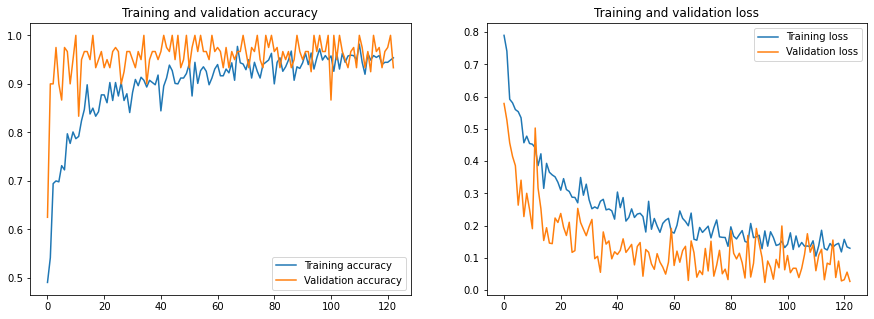

In [8]:
plot_accuracy_and_loss(history)

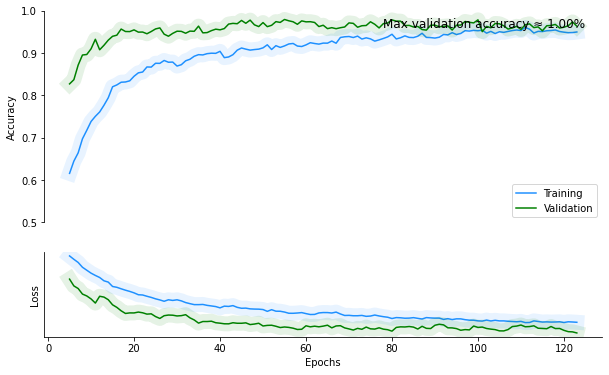

In [9]:
plot_history(history,xkcd=False)

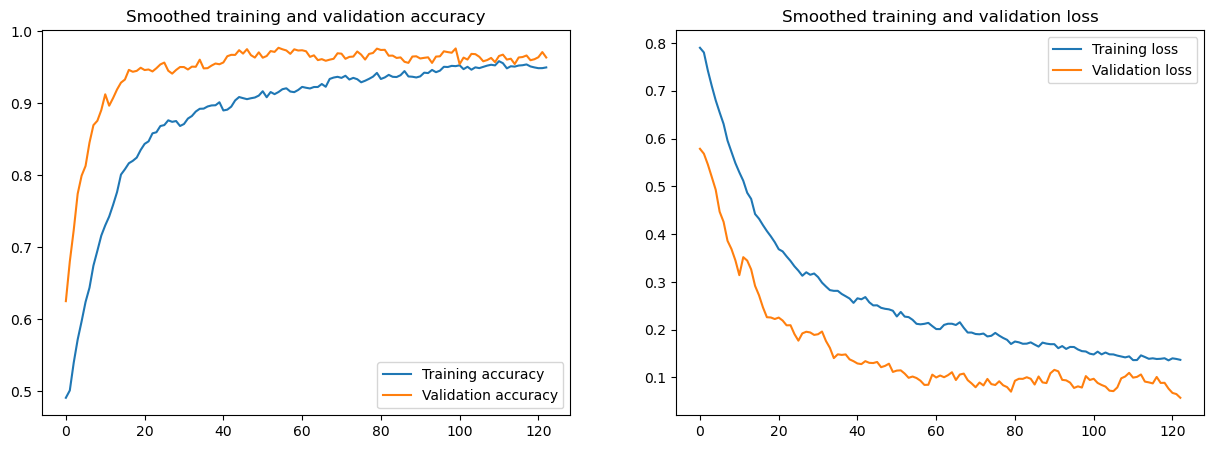

In [10]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [11]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 224, 224, 3)


In [12]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  412
Number of train classes:  3
Number of train samples per class: 137 

Number of validation samples:  88
Number of validation classes:  3
Number of validation samples per class: 29 

Number of test samples:  89
Number of test classes:  3
Number of test samples per class: 30 

Files for train subset for 3 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

## Model

In [13]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 6s - loss: 1.2781 - acc: 0.3852 - val_loss: 0.9922 - val_acc: 0.4625

Epoch 00001: val_loss improved from inf to 0.99217, saving model to tl_freeze_conv_base_data_aug_3_breeds
Epoch 2/1000
 - 5s - loss: 1.1396 - acc: 0.4362 - val_loss: 0.8321 - val_acc: 0.6765

Epoch 00002: val_loss improved from 0.99217 to 0.83208, saving model to tl_freeze_conv_base_data_aug_3_breeds
Epoch 3/1000
 - 4s - loss: 1.0810 - acc: 0.4770 - val_loss: 0.8752 - val_acc: 0.5441

Epoch 00003: val_loss did not improve from 0.83208
Epoch 4/1000
 - 4s - loss: 0.9708 - acc: 0.5357 - val_loss: 0.8034 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.83208 to 0.80342, saving model to tl_freeze_conv_base_data_aug_3_breeds
Epoch 5/1000
 - 4s - loss: 0.9086 - acc: 0.5600 - val_loss: 0.6508 - val_acc: 0.8088

Epoch 00005: val_loss improved from 0.80342 to 0.65083, saving model to tl_freeze_conv_base_data_aug_3_breeds
Epoch 6/1000
 - 4s - loss: 0.8856 - acc: 0.5885 - val_loss: 0.6191 - val_acc: 0.875

## Results

In [16]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 2s 18ms/step


[0.09509277770693382, 0.9775280952453613]

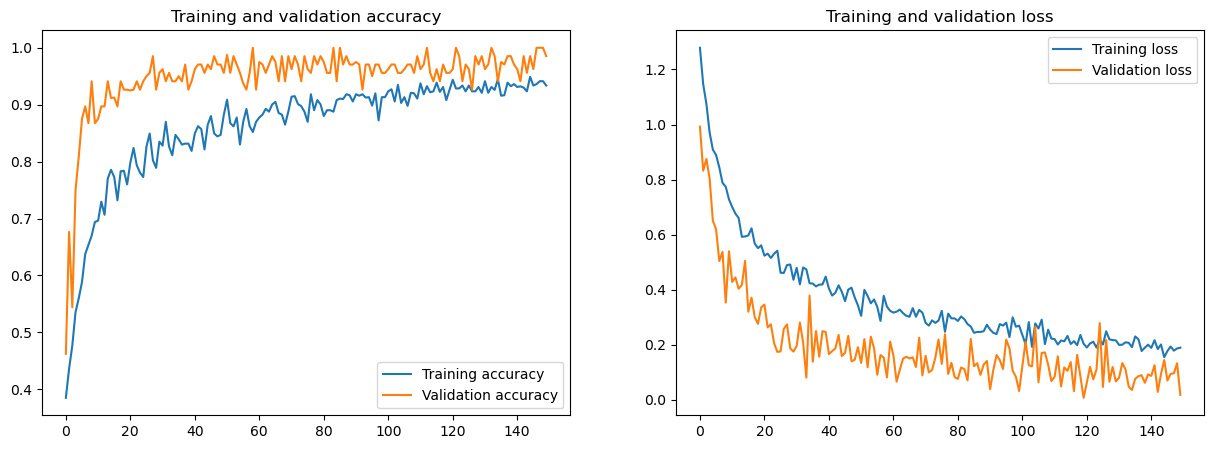

In [17]:
plot_accuracy_and_loss(history)

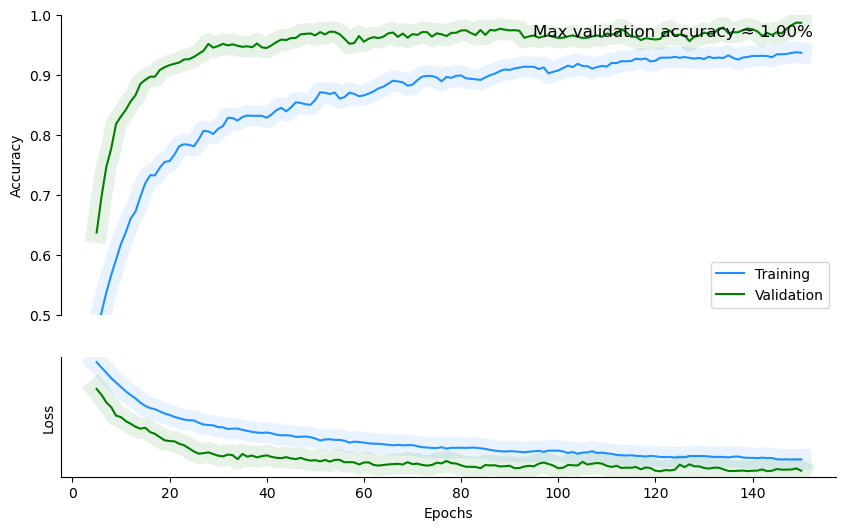

In [18]:
plot_history(history,xkcd=False)

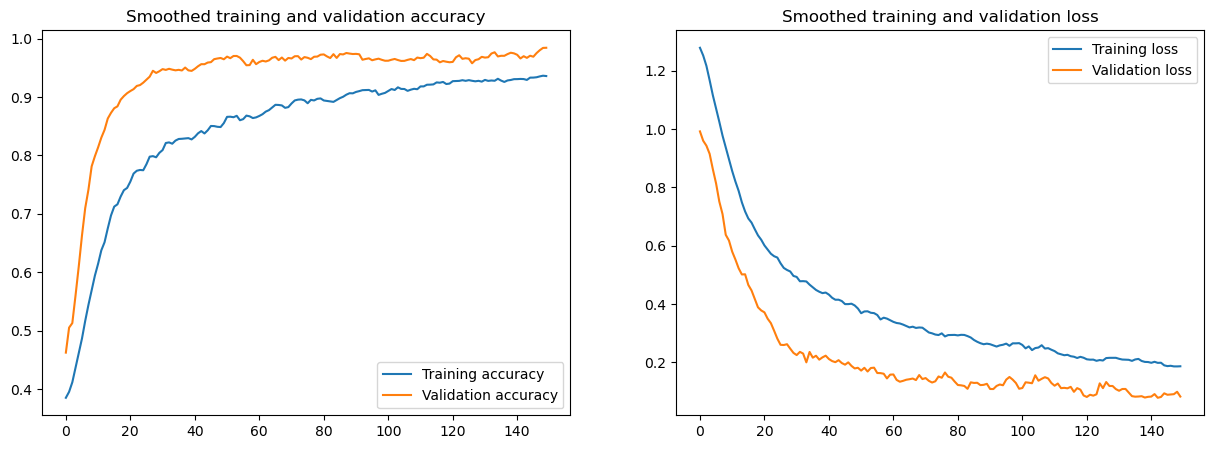

In [19]:
plot_smoothed_acc_and_loss(history, 0.8)

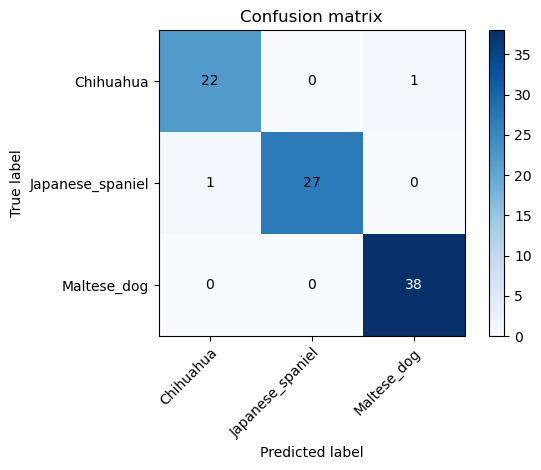

In [20]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [21]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 224, 224, 3)


In [22]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  666
Number of train classes:  5
Number of train samples per class: 133 

Number of validation samples:  143
Number of validation classes:  5
Number of validation samples per class: 29 

Number of test samples:  143
Number of test classes:  5
Number of test samples per class: 29 

Files for train subset for 5 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\

## Model

In [23]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 8s - loss: 1.8020 - acc: 0.2307 - val_loss: 1.3189 - val_acc: 0.3500

Epoch 00001: val_loss improved from inf to 1.31892, saving model to tl_freeze_conv_base_data_aug_5_breeds
Epoch 2/1000
 - 8s - loss: 1.6495 - acc: 0.2817 - val_loss: 1.3703 - val_acc: 0.4309

Epoch 00002: val_loss did not improve from 1.31892
Epoch 3/1000
 - 7s - loss: 1.6379 - acc: 0.3034 - val_loss: 1.5095 - val_acc: 0.5285

Epoch 00003: val_loss did not improve from 1.31892
Epoch 4/1000
 - 7s - loss: 1.5725 - acc: 0.3127 - val_loss: 1.3587 - val_acc: 0.5772

Epoch 00004: val_loss did not improve from 1.31892
Epoch 5/1000
 - 7s - loss: 1.4593 - acc: 0.3653 - val_loss: 1.3303 - val_acc: 0.5122

Epoch 00005: val_loss did not improve from 1.31892
Epoch 6/1000
 - 7s - loss: 1.4360 - acc: 0.3978 - val_loss: 1.0408 - val_acc: 0.6016

Epoch 00006: val_loss improved from 1.31892 to 1.04078, saving model to tl_freeze_conv_base_data_aug_5_breeds
Epoch 7/1000
 - 7s - loss: 1.3783 - acc: 0.4136 - val_loss: 1.22

## Results

In [26]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 1s 5ms/step


[0.7277980946994328, 0.7132866978645325]

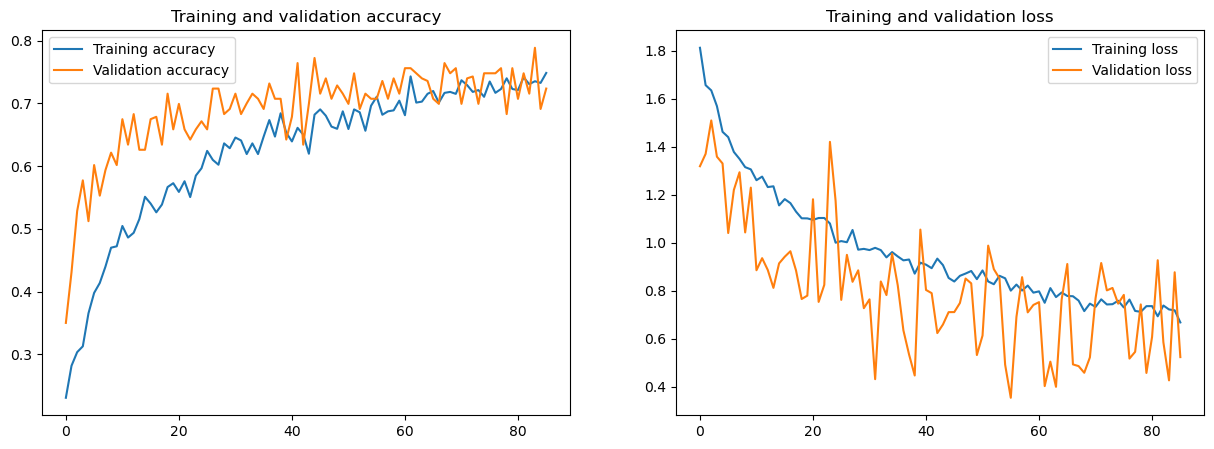

In [27]:
plot_accuracy_and_loss(history)

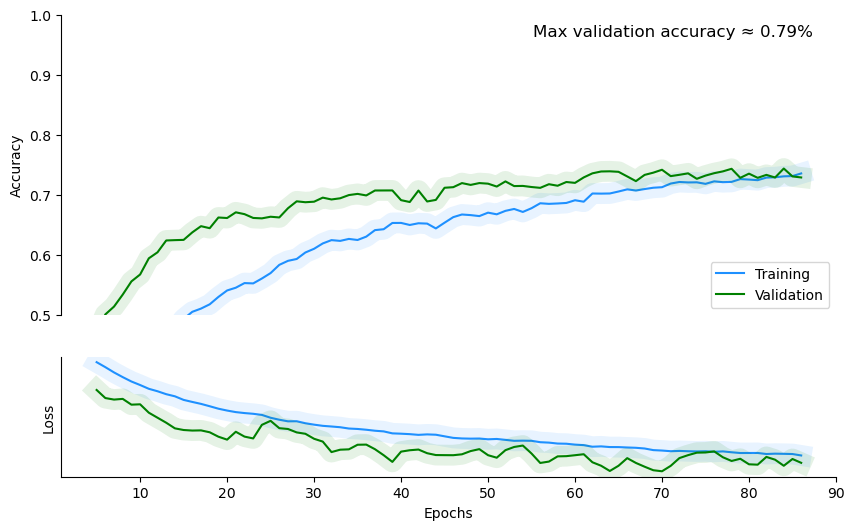

In [28]:
plot_history(history,xkcd=False)

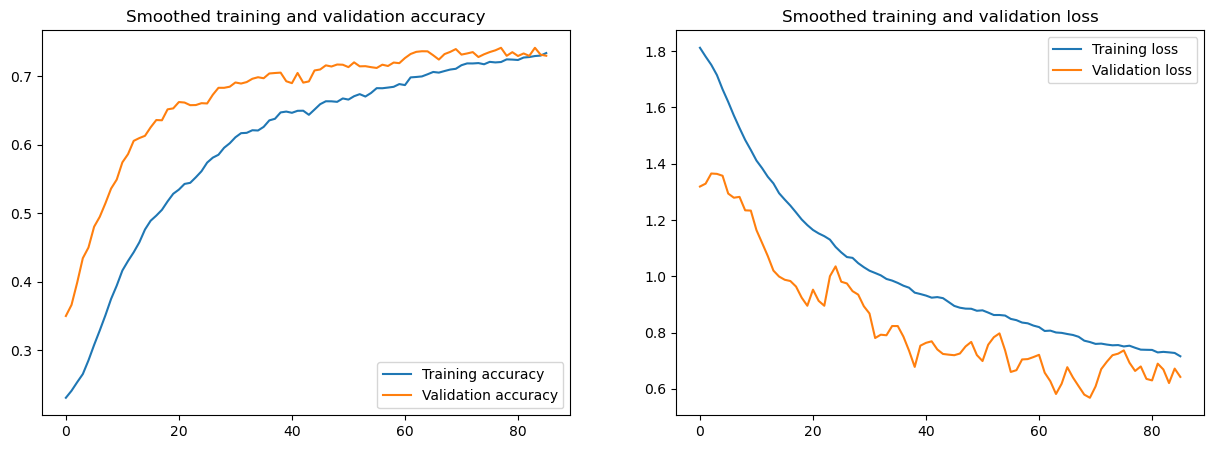

In [29]:
plot_smoothed_acc_and_loss(history, 0.8)

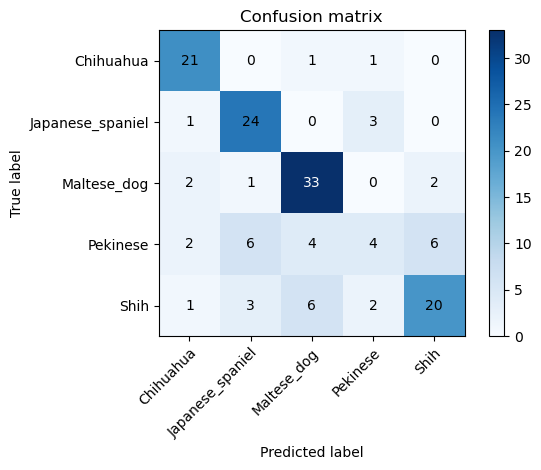

In [30]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [31]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

In [32]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  7072
Number of train classes:  60
Number of train samples per class: 118 

Number of validation samples:  1527
Number of validation classes:  60
Number of validation samples per class: 25 

Number of test samples:  1512
Number of test classes:  60
Number of test samples per class: 25 

Files for train subset for 60 classes 
 ['affenpinscher\\n02110627_10147.jpg', 'affenpinscher\\n02110627_10185.jpg', 'affenpinscher\\n02110627_10225.jpg', 'affenpinscher\\n02110627_10437.jpg', 'affenpinscher\\n02110627_10439.jpg', 'affenpinscher\\n02110627_10447.jpg', 'affenpinscher\\n02110627_10680.jpg', 'affenpinscher\\n02110627_10787.jpg', 'affenpinscher\\n02110627_10848.jpg', 'affenpinscher\\n02110627_10859.jpg', 'affenpinscher\\n02110627_10986.jpg', 'affenpinscher\\n02110627_11211.jpg', 'affenpinscher\\n02110627_11262.jpg', 'affenpinscher\\n02110627_11263.jpg', 'affenpinscher\\n02110627_11279.jpg', 'affenpinscher\\n02110627_11283.jpg', 'affenpinscher\\n02110627_11345.jpg', 

## Model

In [33]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 83s - loss: 4.1390 - acc: 0.0244 - val_loss: 4.0631 - val_acc: 0.0467

Epoch 00001: val_loss improved from inf to 4.06305, saving model to tl_freeze_conv_base_data_aug_60_breeds
Epoch 2/1000
 - 79s - loss: 4.0345 - acc: 0.0335 - val_loss: 3.8899 - val_acc: 0.0478

Epoch 00002: val_loss improved from 4.06305 to 3.88995, saving model to tl_freeze_conv_base_data_aug_60_breeds
Epoch 3/1000
 - 78s - loss: 3.9548 - acc: 0.0465 - val_loss: 3.7558 - val_acc: 0.0989

Epoch 00003: val_loss improved from 3.88995 to 3.75583, saving model to tl_freeze_conv_base_data_aug_60_breeds
Epoch 4/1000
 - 78s - loss: 3.8743 - acc: 0.0583 - val_loss: 3.9918 - val_acc: 0.1102

Epoch 00004: val_loss did not improve from 3.75583
Epoch 5/1000
 - 78s - loss: 3.7941 - acc: 0.0777 - val_loss: 3.4851 - val_acc: 0.1374

Epoch 00005: val_loss improved from 3.75583 to 3.48507, saving model to tl_freeze_conv_base_data_aug_60_breeds
Epoch 6/1000
 - 78s - loss: 3.7265 - acc: 0.0798 - val_loss: 3.5075 - val_

## Results

In [36]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 20s 13ms/step


[2.3109780833834694, 0.3928571343421936]

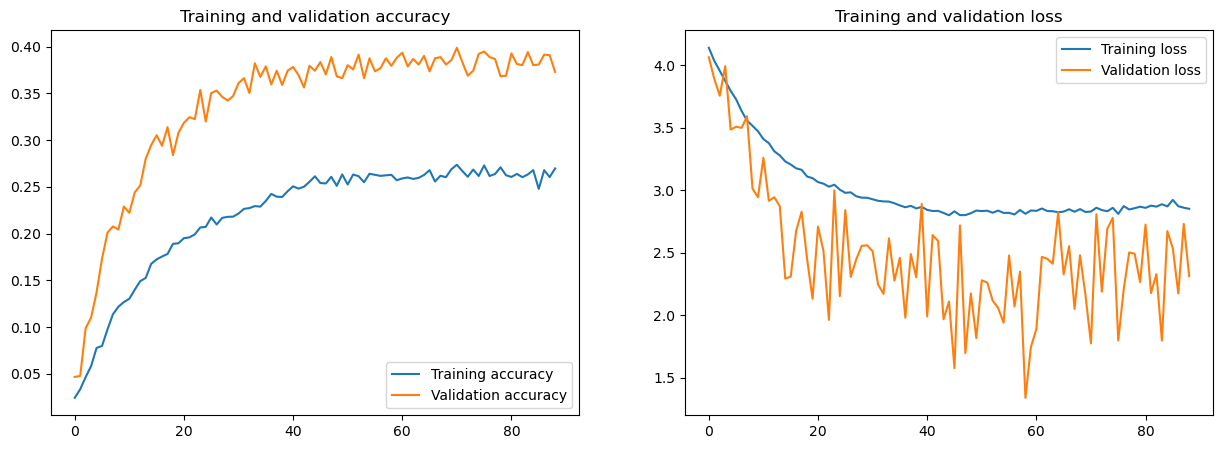

In [37]:
plot_accuracy_and_loss(history)

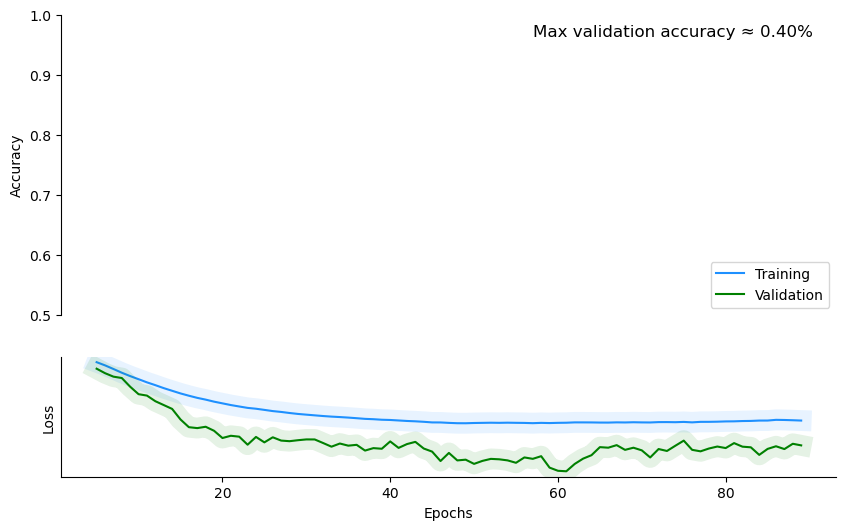

In [38]:
plot_history(history,xkcd=False)

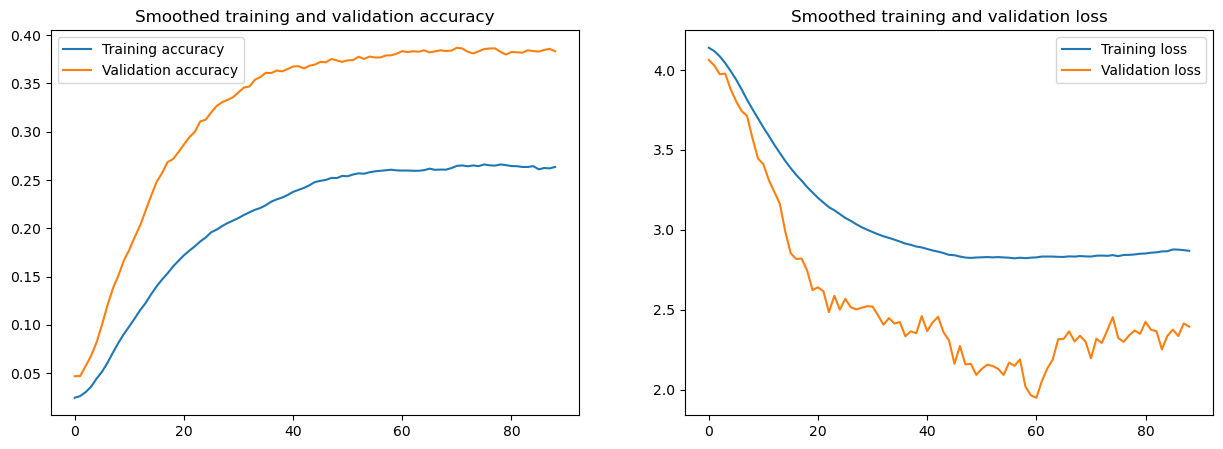

In [39]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

## Data preparation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

# Model

In [4]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

conv_base.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_data_aug_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_data_aug_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 189s - loss: 4.8135 - acc: 0.0104 - val_loss: 4.8133 - val_acc: 0.0208

Epoch 00001: val_loss improved from inf to 4.81333, saving model to tl_freeze_conv_base_data_aug_120_breeds
Epoch 2/1000
 - 160s - loss: 4.7386 - acc: 0.0139 - val_loss: 4.6847 - val_acc: 0.0286

Epoch 00002: val_loss improved from 4.81333 to 4.68468, saving model to tl_freeze_conv_base_data_aug_120_breeds
Epoch 3/1000
 - 156s - loss: 4.6723 - acc: 0.0191 - val_loss: 4.5860 - val_acc: 0.0380

Epoch 00003: val_loss improved from 4.68468 to 4.58597, saving model to tl_freeze_conv_base_data_aug_120_breeds
Epoch 4/1000
 - 157s - loss: 4.6029 - acc: 0.0232 - val_loss: 4.2459 - val_acc: 0.0412

Epoch 00004: val_loss improved from 4.58597 to 4.24591, saving model to tl_freeze_conv_base_data_aug_120_breeds
Epoch 5/1000
 - 155s - loss: 4.5350 - acc: 0.0300 - val_loss: 4.3850 - val_acc: 0.0507

Epoch 00005: val_loss did not improve from 4.24591
Epoch 6/1000
 - 156s - loss: 4.4755 - acc: 0.0314 - val_loss: 4.3

## Results

In [7]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 25s 8ms/step


[3.4979566120761225, 0.1780155599117279]

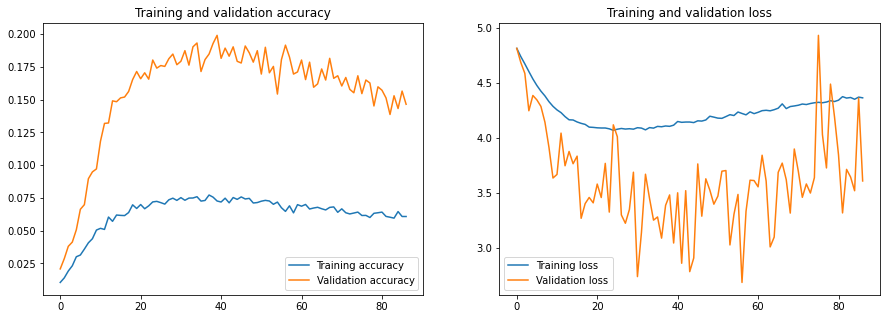

In [8]:
plot_accuracy_and_loss(history)

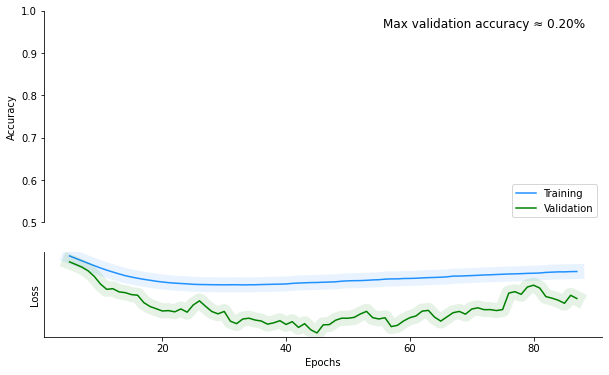

In [9]:
plot_history(history,xkcd=False)

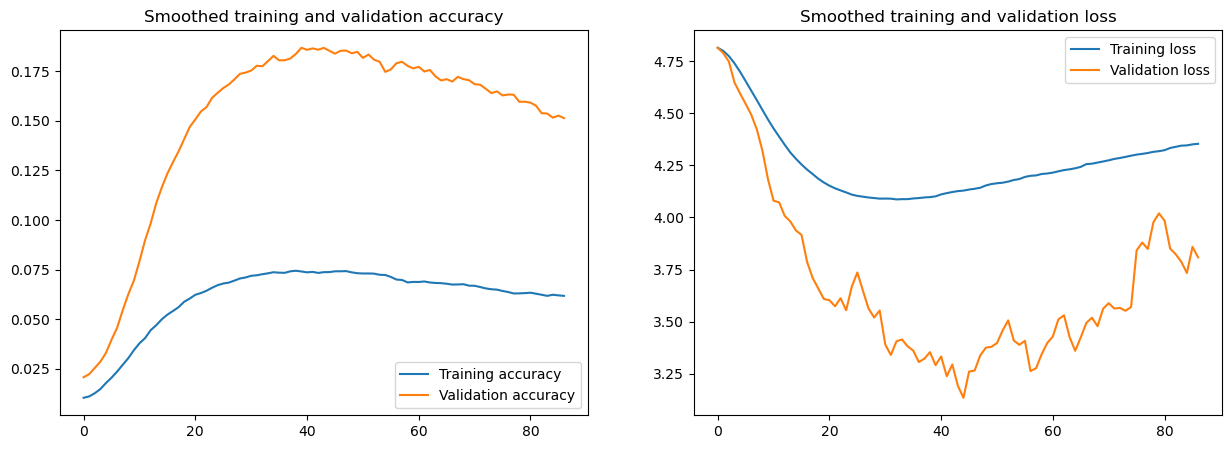

In [10]:
plot_smoothed_acc_and_loss(history, 0.8)